# Initialize tutorial

First, we perform some initial steps to set up the tutorial.

In [1]:
# Remove this part!
# import sys
# sys.path.insert(0,"../../")

import random
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import neo
from neo.io import NeoHdf5IO
import elephant.unitary_event_analysis as ue

# Fix random seed to guarantee fixed output
random.seed(1224)

Next, we download a data file containing spike train data from multiple trials of two neurons.

In [3]:
# Download data
!wget -Nq https://github.com/INM-6/elephant-tutorial-data/raw/master/dataset-1/dataset-1.h5

# Write a plotting function

In [3]:
def plot_UE(data,Js_dict,Js_sig,binsize,winsize,winstep, pat,N,t_winpos,**kwargs):
    """
    Examples:
    ---------
    dict_args = {'events':{'SO':[100*pq.ms]},
     'save_fig': True,
     'path_filename_format':'UE1.pdf',
     'showfig':True,
     'suptitle':True,
     'figsize':(12,10),
    'unit_ids':[10, 19, 20],
    'ch_ids':[1,3,4],
    'fontsize':15,
    'linewidth':2,
    'set_xticks' :False'}
    'marker_size':8,
    """
    import matplotlib.pylab as plt
    t_start = data[0][0].t_start
    t_stop = data[0][0].t_stop


    arg_dict = {'events':{},'figsize':(12,10), 'top':0.9, 'bottom':0.05, 'right':0.95,'left':0.1,
                'hspace':0.5,'wspace':0.5,'fontsize':15,'unit_ids':range(1,N+1,1),
                'ch_real_ids':[],'showfig':False, 'lw':2,'S_ylim':[-3,3],
                'marker_size':8, 'suptitle':False, 'set_xticks':False,
                'save_fig':False,'path_filename_format':'UE.pdf'}
    arg_dict.update(kwargs)
    
    num_tr = len(data)
    unit_real_ids = arg_dict['unit_ids']
    
    num_row = 5
    num_col = 1
    ls = '-'
    alpha = 0.5
    plt.figure(1,figsize = arg_dict['figsize'])
    if arg_dict['suptitle'] == True:
        plt.suptitle("Spike Pattern:"+ str((pat.T)[0]),fontsize = 20)
    print('plotting UEs ...')
    plt.subplots_adjust(top=arg_dict['top'], right=arg_dict['right'], left=arg_dict['left']
                        , bottom=arg_dict['bottom'], hspace=arg_dict['hspace'] , wspace=arg_dict['wspace'])
    ax = plt.subplot(num_row,1,1)
    ax.set_title('Unitary Events',fontsize = arg_dict['fontsize'],color = 'r')
    for n in range(N):
        for tr,data_tr in enumerate(data):
            plt.plot(data_tr[n].rescale('ms').magnitude, np.ones_like(data_tr[n].magnitude)*tr + n*(num_tr + 1) + 1, '.', markersize=0.5,color = 'k')
            sig_idx_win = np.where(Js_dict['Js']>= Js_sig)[0]
            if len(sig_idx_win)>0:
                x = np.unique(Js_dict['indices']['trial'+str(tr)])
                if len(x)>0:
                    xx = []
                    for j in sig_idx_win:
                        xx =np.append(xx,x[np.where((x*binsize>=t_winpos[j]) &(x*binsize<t_winpos[j] + winsize))])
                    plt.plot(
                        np.unique(xx)*binsize, np.ones_like(np.unique(xx))*tr + n*(num_tr + 1) + 1,
                        ms=arg_dict['marker_size'], marker = 's', ls = '',mfc='none', mec='r')
        plt.axhline((tr + 2)*(n+1) ,lw = 2, color = 'k')
    y_ticks_pos = np.arange(num_tr/2 + 1,N*(num_tr+1), num_tr+1)
    plt.yticks(y_ticks_pos)
    plt.gca().set_yticklabels(unit_real_ids,fontsize = arg_dict['fontsize'])
    for ch_cnt, ch_id in enumerate(arg_dict['ch_real_ids']):
        print(ch_id)
        plt.gca().text((max(t_winpos) + winsize).rescale('ms').magnitude,
                       y_ticks_pos[ch_cnt],'CH-'+str(ch_id),fontsize = arg_dict['fontsize'])

    plt.ylim(0, (tr + 2)*(n+1) + 1)
    plt.xlim(0, (max(t_winpos) + winsize).rescale('ms').magnitude)
    plt.xticks([])
    plt.ylabel('Unit ID',fontsize = arg_dict['fontsize'])
    for key in arg_dict['events'].keys():
        for e_val in arg_dict['events'][key]:
            plt.axvline(e_val,ls = ls,color = 'r',lw = 2,alpha = alpha)
    if arg_dict['set_xticks'] == False:
        plt.xticks([])
    print('plotting Raw Coincidences ...')
    ax1 = plt.subplot(num_row,1,2,sharex = ax)
    ax1.set_title('Raw Coincidences',fontsize = 20,color = 'c')
    for n in range(N):
        for tr,data_tr in enumerate(data):
            plt.plot(data_tr[n].rescale('ms').magnitude,
                     np.ones_like(data_tr[n].magnitude)*tr + n*(num_tr + 1) + 1,
                     '.', markersize=0.5, color = 'k')
            plt.plot(
                np.unique(Js_dict['indices']['trial'+str(tr)])*binsize,
                np.ones_like(np.unique(Js_dict['indices']['trial'+str(tr)]))*tr + n*(num_tr + 1) + 1,
                ls = '',ms=arg_dict['marker_size'], marker = 's', markerfacecolor='none', markeredgecolor='c')
        plt.axhline((tr + 2)*(n+1) ,lw = 2, color = 'k')
    plt.ylim(0, (tr + 2)*(n+1) + 1)
    plt.yticks(np.arange(num_tr/2 + 1,N*(num_tr+1), num_tr+1))
    plt.gca().set_yticklabels(unit_real_ids,fontsize = arg_dict['fontsize'])
    plt.xlim(0, (max(t_winpos) + winsize).rescale('ms').magnitude)
    plt.xticks([])
    plt.ylabel('Unit ID',fontsize = arg_dict['fontsize'])
    for key in arg_dict['events'].keys():
        for e_val in arg_dict['events'][key]:
            plt.axvline(e_val,ls = ls,color = 'r',lw = 2,alpha = alpha)

    print('plotting PSTH ...')
    plt.subplot(num_row,1,3,sharex=ax)
    #max_val_psth = 0.*pq.Hz
    for n in range(N):
        plt.plot(t_winpos + winsize/2.,Js_dict['rate_avg'][:,n].rescale('Hz'),
                 label = 'unit '+str(arg_dict['unit_ids'][n]),lw = arg_dict['lw'])
    plt.ylabel('Rate [Hz]',fontsize = arg_dict['fontsize'])
    plt.xlim(0, (max(t_winpos) + winsize).rescale('ms').magnitude)
    max_val_psth = plt.gca().get_ylim()[1]
    plt.ylim(0, max_val_psth)
    plt.yticks([0, int(max_val_psth/2),int(max_val_psth)],fontsize = arg_dict['fontsize'])
    plt.legend(bbox_to_anchor=(1.12, 1.05), fancybox=True, shadow=True)
    for key in arg_dict['events'].keys():
        for e_val in arg_dict['events'][key]:
            plt.axvline(e_val,ls = ls,color = 'r',lw = arg_dict['lw'],alpha = alpha)

    if arg_dict['set_xticks'] == False:
        plt.xticks([])
    print( 'plotting emp. and exp. coincidences rate ...')
    plt.subplot(num_row,1,4,sharex=ax)
    plt.plot(t_winpos + winsize/2.,Js_dict['n_emp'],label = 'empirical',lw = arg_dict['lw'],color = 'c')
    plt.plot(t_winpos + winsize/2.,Js_dict['n_exp'],label = 'expected',lw = arg_dict['lw'],color = 'm')
    plt.xlim(0, (max(t_winpos) + winsize).rescale('ms').magnitude)
    plt.ylabel('# Coinc.',fontsize = arg_dict['fontsize'])
    plt.legend(bbox_to_anchor=(1.12, 1.05), fancybox=True, shadow=True)
    YTicks = plt.ylim(0,int(max(max(Js_dict['n_emp']), max(Js_dict['n_exp']))))
    plt.yticks([0,YTicks[1]],fontsize = arg_dict['fontsize'])
    for key in arg_dict['events'].keys():
        for e_val in arg_dict['events'][key]:
            plt.axvline(e_val,ls = ls,color = 'r',lw = 2,alpha = alpha)
    if arg_dict['set_xticks'] == False:
        plt.xticks([])

    print('plotting Surprise ...')
    plt.subplot(num_row,1,5,sharex=ax)
    plt.plot(t_winpos + winsize/2., Js_dict['Js'],lw = arg_dict['lw'],color = 'k')
    plt.xlim(0, (max(t_winpos) + winsize).rescale('ms').magnitude)
    plt.axhline(Js_sig,ls = '-', color = 'gray')
    plt.axhline(-Js_sig,ls = '-', color = 'gray')
    plt.xticks(t_winpos.magnitude[::len(t_winpos)/10])
    plt.yticks([-2,0,2],fontsize = arg_dict['fontsize'])
    plt.ylabel('S',fontsize = arg_dict['fontsize'])
    plt.xlabel('Time [ms]', fontsize = arg_dict['fontsize'])
    plt.ylim(arg_dict['S_ylim'])
    for key in arg_dict['events'].keys():
        for e_val in arg_dict['events'][key]:
            plt.axvline(e_val,ls = ls,color = 'r',lw = arg_dict['lw'],alpha = alpha)
            plt.gca().text(e_val - 10*pq.ms,2*arg_dict['S_ylim'][0],key,fontsize = arg_dict['fontsize'],color = 'r')

    if arg_dict['set_xticks'] == False:
        plt.xticks([])

    if arg_dict['save_fig'] == True:
        plt.savefig(arg_dict['path_filename_format'])
        if arg_dict['showfig'] == False:
            plt.cla()
            plt.close()

    if arg_dict['showfig'] == True:
        plt.show()

# Load data and extract spiketrains

In [4]:
block = NeoHdf5IO("./unitary_events_data.h5")
sts1 = block.read_block().segments[0].spiketrains
sts2 = block.read_block().segments[1].spiketrains
spiketrains = np.vstack((sts1,sts2)).T

# Calculate Unitary Events

plotting UEs ...
plotting Raw Coincidences ...
plotting PSTH ...
plotting emp. and exp. coincidences rate ...
plotting Surprise ...


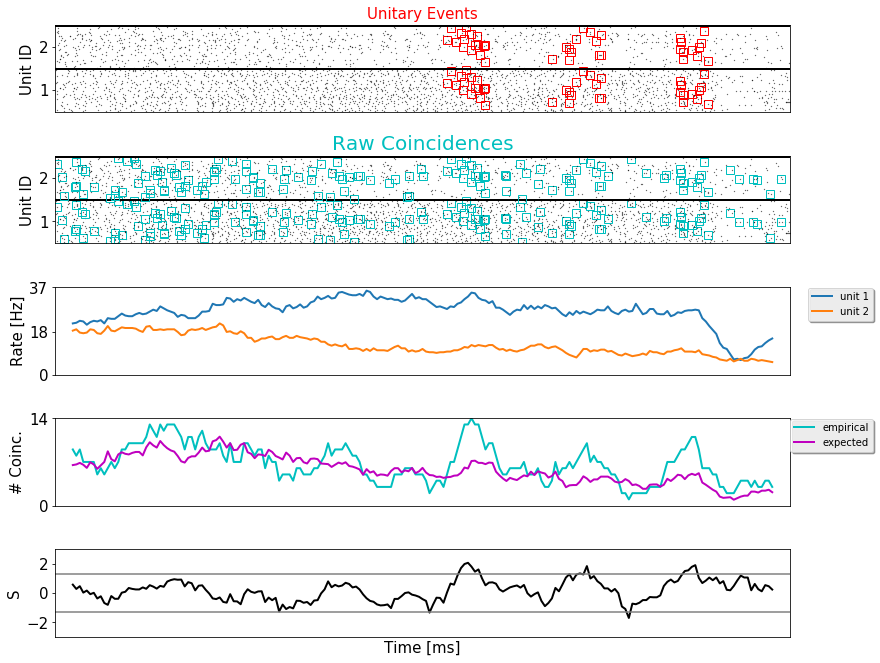

In [5]:
UE = ue.unitary_event_analysis(
    spiketrains, bin_size=5*pq.ms, window_size=100*pq.ms, window_step=10*pq.ms, pattern_hash=[3])

plot_UE(
        spiketrains, UE, ue.jointJ(0.05),binsize=5*pq.ms,winsize=100*pq.ms,winstep=10*pq.ms,
        pat=ue.inverse_hash_from_pattern([3], N=2), N=2,
        t_winpos=ue._winpos(0*pq.ms,spiketrains[0][0].t_stop,winsize=100*pq.ms,winstep=10*pq.ms))
plt.show()